#  <h1><center>Computer aided detection of cancer in endoscopic images</center></h1>

> Considering this assignment is a classification problem for image, CNN normally could have good performance even with raw data, I built a CNN model for the assignment and it achieved the accuracy of 0.93, sensitivity of 0.89, and specificity of 0.95  in test set, this will be compared with results of linear SVM with extracted features in this assignment. (The CNN code is at the end of this report)

1.Visualize the obtained HOG features for a tile of a healthy tissue and a tile of cancerous tissue.

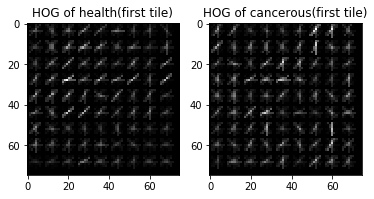

2.Report on your choice of features and motivate it.

Firstly, I extracted HOG features for tiles to capture the local shape information, the examples were shown in previous question, I set 8 pixels for each cell, so it can be seen that 9 shape information in each row and column. They should be distiguishable, since the shape in each cell is different for health and cancerous tiles.<br>
Secondly, the Haralick feature was extracted as texture features. Since textures are derived from components that are themselves similar, placed together regularly or randomly, I think our tissue tiles match this property, so the texture feature also should work.<br>
Finally, some statistic features of pixels were extracted like the mean, standard deviation and skewness for every channel. In addition the color histogram was also created as feature. These statistic features can work because for example if we looked at the images we could find that usually the color of healthy tiles is more uniform which means the standard deviation should be smaller. In addition, cancerous tiles tend to have some bright spots, so the color histogram also could make some contribution.

3.Evaluate the performance and report accuracy, sensitivity and specificity.

After feeding all the above features and selecting parameters of linear SVM with 5 fold cross validation based on accuracy, the classifier got accuracy of 0.81, sensitivity of 0.79, and specificity of 0.83 in test set

4.Explore effects of different features combination on your classification performance. Plot ROC curves for each setting

The figure below shows the ROC for texture features, HOG features, the combination of them and all the extracted features.<br>
It can be seen that when we just used texture features and HOG features seperately we got AUC of 0.80 and 0.74 respectively. Superisedly, when texture and HOG were applied together, the AUC didn't increase. The reason could be that the combination contained some redundant feature columns which led to collinearity. Drop the highly correlated feature columns may help in this case.<br>Ultimately, the highest AUC came from all extracted features, this indicated that the other statistic features and color histogram features provided some additional information to distiguish healthy and cancerous tiles of tissue.<br> We can conclude from the figure that the increase of number of features can not necessarily improve the performance, but the more independent and informative features really matter.

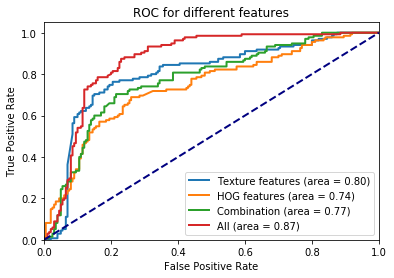

5.(To get 10) the image patches you have classified are tiled out from the actual frames of an endoscopic inspection video. From the frames provided, extract tiles with the same size as you trained your classifier with. Perform step vi and obtain a
contour for the cancerous tissues at each frame.

The figures below show the classified results for four frames by SVM and CNN respectively, note that the black boxes(75*75) mean the cancerous tiles detected by classifier. The related code is in appendix.<br>
We can see from the results that compared with linear SVM, CNN has higher accuracy sensitivity and specficity. The reason would be<br> 1. This classification problem is not linear, so the linear SVM just can't have excellent performance.<br> 2.The features we extracted for SVM are redundant, feature selection should be implemented before feeding SVM.<br> 3.Some advanced distinguishable features are not extrated by us, like the parameters of HOG and texture features need to be tuned further.<br> 4.The machine in CNN captures some very useful features, maybe they are too special to even be realized by people.

<img src="SVM_1.png"><img src="CNN_1.png"><img src="SVM_2.png"><img src="CNN_2.png"><img src="SVM_3.png"><img src="CNN_3.png"><img src="SVM_4.png"><img src="CNN_4.png">

### Appendix

All the script for each question is shown below. CNN is at the end of the code

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from scipy.stats import skew
import pylab as plt
np.random.seed(99)
from keras.models import model_from_json ## For reproducibility
import cv2
import glob
from skimage.util.shape import view_as_blocks
from skimage.feature import hog,greycomatrix,greycoprops
from skimage.color import rgb2gray
from skimage import img_as_ubyte
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,auc
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
### Function of features
def HOG_feature(image_array):
    feat_HOG = pd.DataFrame([hog(rgb2gray(image),8,cells_per_block=(1, 1)) for image in image_array])
    feat_HOG.columns=['HOG_%d'%i for i in range(feat_HOG.shape[1])]
    return feat_HOG
def texture_feature(image_array):
    dissimilarity = pd.DataFrame()
    contrast = pd.DataFrame()
    homogeneity = pd.DataFrame()
    energy = pd.DataFrame()
    correlation = pd.DataFrame()
    for image in image_array:
        glcms = greycomatrix(img_as_ubyte(rgb2gray(image)),
                         distances=[1],
                         angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                         levels=256,
                         symmetric=True)
        contrast = pd.concat([contrast,pd.DataFrame(greycoprops(glcms, prop='contrast'))])
        dissimilarity = pd.concat([dissimilarity,pd.DataFrame(greycoprops(glcms, prop='dissimilarity'))])
        homogeneity = pd.concat([homogeneity,pd.DataFrame(greycoprops(glcms, prop='homogeneity'))])
        energy = pd.concat([energy,pd.DataFrame(greycoprops(glcms, prop='energy'))])
        correlation = pd.concat([correlation,pd.DataFrame(greycoprops(glcms, prop='correlation'))])
    contrast.columns = ['contrast_0','contrast_45','contrast_90','contrast_135']
    dissimilarity.columns = ['dissimilarity_0','dissimilarity_45','dissimilarity_90','dissimilarity_135']
    homogeneity.columns = ['homogeneity_0','homogeneity_45','homogeneity_90','homogeneity_135']
    energy.columns = ['energy_0','energy_45','energy_90','energy_135']
    correlation.columns = ['correlation_0','correlation_45','correlation_90','correlation_135']
    feat_text = pd.concat([contrast,dissimilarity,homogeneity,energy,correlation],axis=1)
    return feat_text
def statistic_feature(image_array):
    feat_stat = pd.DataFrame()
    ### mean for each channel
    feat_stat['mean_R'] = [image[:,:,0].mean() for image in image_array]
    feat_stat['mean_G'] = [image[:,:,1].mean() for image in image_array]
    feat_stat['mean_B'] = [image[:,:,2].mean() for image in image_array]
    ### std for each channel
    feat_stat['std_R'] = [image[:,:,0].std() for image in image_array]
    feat_stat['std_G'] = [image[:,:,1].std() for image in image_array]
    feat_stat['std_B'] = [image[:,:,2].std() for image in image_array]
    ### std for each channel
    feat_stat['skew_R'] = [skew(image[:,:,0].reshape(-1)) for image in image_array]
    feat_stat['skew_G'] = [skew(image[:,:,1].reshape(-1)) for image in image_array]
    feat_stat['skew_B'] = [skew(image[:,:,2].reshape(-1)) for image in image_array]
    return feat_stat
def color_his_feature(image_array):
    feat_his = pd.DataFrame([np.histogram(image, bins=10)[0] for image in image_array],
                            columns=['color_his_%d'%i for i in range(10)])
    return feat_his

In [56]:
def contourPlot(frame,clf,clf_name,scaler):
    ### Drop some two ended pixels to extract tiles
    frame = frame[:,18:1160-17,13:1000-12,:]
    ### Split the frame into tiles
    frame_patches = np.array([view_as_blocks(patient, block_shape=(75,75,3)) for patient in frame])
    ### Change the image shape for classifier
    frame_clf = frame_patches.reshape(4,-1,75,75,3)
    if clf_name=='CNN':
        frame_clf = frame_clf/255 ##Normalization
        frame_pred = np.array([(clf.predict(patient)>=0.5).astype('int')
                               for patient in frame_clf]).reshape(4,-1)
    elif clf_name=='SVM':
        frame_feat = np.array([scaler.transform(pd.concat([HOG_feature(patient).reset_index(drop=True),
                                 texture_feature(patient).reset_index(drop=True),
                                 statistic_feature(patient).reset_index(drop=True),
                                 color_his_feature(patient).reset_index(drop=True)
                                ],axis=1)) for patient in frame_clf])
        frame_pred = np.array([clf.predict(patient) for patient in frame_feat])
    ### Black the cancerous tiles
    frame_cont = frame_patches.copy()    
    for pat in range(frame_pred.shape[0]):
        for tile in range(frame_pred.shape[1]):
            if frame_pred[pat,tile]==1:
                frame_cont[pat,tile//frame_cont.shape[2],tile%frame_cont.shape[2],0,:,:,:]=0
        plt.figure()
        plt.subplot(121)
        plt.imshow(frame_patches[pat].transpose(0,3,1,4,2,5).reshape(1125,975,3))
        plt.title('Origin, Patient %d'%(pat+1))
        plt.subplot(122)
        plt.imshow(frame_cont[pat].transpose(0,3,1,4,2,5).reshape(1125,975,3))
        plt.title('Classified, Patient %d by %s'%((pat+1),clf_name))
    print('The black part represents detected cancerous tissue')

In [4]:
def classify(X_train,y_train,X_test):
    ### Feature normalization
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    ### Classification with all features
    parameters = {'C':np.logspace(-3,-2,6)}
    clf = GridSearchCV(SVC(kernel='linear',probability=True), 
                       parameters, cv=5, scoring='accuracy')
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    y_proba = clf.predict_proba(X_test_scaled)[:,1]
    return y_pred,y_proba,clf,scaler

Data preparation

In [5]:
### Load negative and positive cases in training set
train_neg = list(map(cv2.imread, glob.glob('Train/other/*.jpg')))
train_pos = list(map(cv2.imread, glob.glob('Train/tumor/*.jpg')))

In [6]:
### Convert them to RGB value and the format for CNN
train_neg_RGB = np.array(list(map(cv2.cvtColor,train_neg,[cv2.COLOR_BGR2RGB]*len(train_neg))))
train_pos_RGB = np.array(list(map(cv2.cvtColor,train_pos,[cv2.COLOR_BGR2RGB]*len(train_pos))))

In [7]:
### Check the format
train_neg_RGB.shape

(400, 75, 75, 3)

In [8]:
train_pos_RGB.shape

(400, 75, 75, 3)

In [9]:
### Combine them
X_train = np.concatenate((train_neg_RGB,train_pos_RGB))

In [10]:
X_train.shape

(800, 75, 75, 3)

In [11]:
### Set the label for training set
y_train = np.concatenate((np.zeros(len(train_neg_RGB)),np.ones(len(train_neg_RGB))))

In [12]:
### Load test set
test = list(map(cv2.imread, glob.glob('Test/*.jpg')))

In [13]:
X_test = np.array(list(map(cv2.cvtColor,test,[cv2.COLOR_BGR2RGB]*len(test))))

In [14]:
X_test.shape

(335, 75, 75, 3)

In [15]:
### Load the test label
y_test = pd.read_csv('Groundtruth.csv', header=None).values

In [16]:
y_test.shape

(335, 1)

Text(0.5,1,'HOG of cancerous(first tile)')

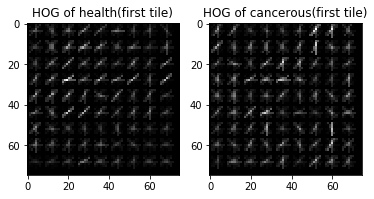

In [17]:
### Visulize the HOG features for a tile of health tissue and cancerous tissue
_,health_hog = hog(rgb2gray(train_neg_RGB[0]),8,cells_per_block=(1, 1),visualise=True)
_,cancer_hog = hog(rgb2gray(train_pos_RGB[0]),8,cells_per_block=(1, 1),visualise=True)
plt.subplot(121)
plt.imshow(health_hog,cmap='gray')
plt.title('HOG of health(first tile)')
plt.subplot(122)
plt.imshow(cancer_hog,cmap='gray')
plt.title('HOG of cancerous(first tile)')

In [18]:
### Combine train and test for feature extraction
train_test = np.concatenate((X_train,X_test))
train_test.shape

(1135, 75, 75, 3)

In [19]:
### Extract HOG
feat_HOG = HOG_feature(train_test)
feat_HOG.shape

(1135, 648)

In [20]:
## Haralick texture features
feat_text = texture_feature(train_test)
feat_text.shape

(1135, 20)

In [21]:
### Statistic features
feat_stat = statistic_feature(train_test)
feat_stat.shape

(1135, 9)

In [22]:
### color histogram
feat_his = color_his_feature(train_test)
feat_his.shape

(1135, 10)

In [23]:
### feature matrix
feat = pd.concat([feat_HOG.reset_index(drop=True),
                  feat_text.reset_index(drop=True),
                  feat_stat.reset_index(drop=True),
                  feat_his.reset_index(drop=True)
                 ],axis=1)
feat.shape

(1135, 687)

In [24]:
### Split the train and test for SVM
X_train_SVM = feat.iloc[:len(y_train),:]
### Split test for svm
X_test_SVM = feat.iloc[len(y_train):,:]

In [26]:
### Classification with all features
y_pred_all,y_proba_all,clf_SVM,scaler = classify(X_train_SVM,y_train,X_test_SVM)

In [27]:
print('Accuracy of linear SVM:%.2f'%accuracy_score(y_test,y_pred_all))

Accuracy of linear SVM:0.81


In [28]:
### Get tn, fp, fn, tp to calculate sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(y_test,y_pred_all).ravel()
print('Sensitivity of linear SVM:%.2f\nSpecificity of linear SVM:%.2f'
      % (tp/(tp+fn),tn/(tn+fp)))

Sensitivity of linear SVM:0.79
Specificity of linear SVM:0.83


In [30]:
### Classification with texture features
y_pred_text,y_proba_text,_,_ = classify(X_train_SVM.iloc[:,feat_HOG.shape[1]:feat_HOG.shape[1]+feat_text.shape[1]],
                                    y_train,
                                    X_test_SVM.iloc[:,feat_HOG.shape[1]:feat_HOG.shape[1]+feat_text.shape[1]])

In [31]:
### Classification with HOG features
y_pred_hog,y_proba_hog,_,_ = classify(X_train_SVM.iloc[:,:feat_HOG.shape[1]],
                                    y_train,
                                    X_test_SVM.iloc[:,:feat_HOG.shape[1]])

In [32]:
### Classification with texture and HOG features
y_pred_th,y_proba_th,_,_ = classify(X_train_SVM.iloc[:,:feat_HOG.shape[1]+feat_text.shape[1]],
                                    y_train,
                                    X_test_SVM.iloc[:,:feat_HOG.shape[1]+feat_text.shape[1]])

In [33]:
### ROC for only texture features
fpr_text, tpr_text, _ = roc_curve(y_test, y_proba_text)
auc_text = auc(fpr_text, tpr_text)
### ROC for only HOG features
fpr_hog, tpr_hog, _ = roc_curve(y_test, y_proba_hog)
auc_hog = auc(fpr_hog, tpr_hog)
### ROC for only text and statistic features
fpr_th, tpr_th, _ = roc_curve(y_test, y_proba_th)
auc_th = auc(fpr_th, tpr_th)
### ROC for all features
fpr_all, tpr_all, _ = roc_curve(y_test, y_proba_all)
auc_all = auc(fpr_all, tpr_all)

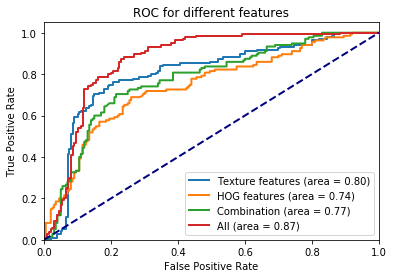

In [34]:
### ROC plot
plt.figure()
lw = 2
plt.plot(fpr_text, tpr_text, 
         lw=lw, label='Texture features (area = %0.2f)' % auc_text)
plt.plot(fpr_hog, tpr_hog,
         lw=lw, label='HOG features (area = %0.2f)' % auc_hog)
plt.plot(fpr_th, tpr_th,
         lw=lw, label='Combination (area = %0.2f)' % auc_th)
plt.plot(fpr_all, tpr_all,
         lw=lw, label='All (area = %0.2f)' % auc_all)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for different features')
plt.legend(loc="lower right")
plt.show()

In [35]:
### Load Frames
frame = list(map(cv2.imread, glob.glob('Frames/*.jpg')))
frame = np.array(list(map(cv2.cvtColor,frame,[cv2.COLOR_BGR2RGB]*len(frame))))
frame.shape

(4, 1160, 1000, 3)

The black part represents detected cancerous tissue


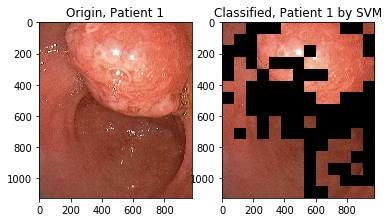

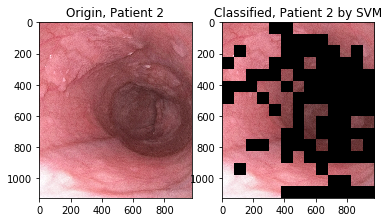

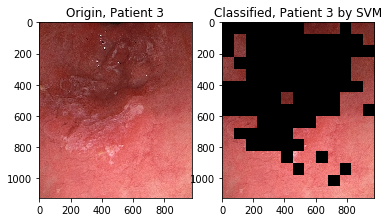

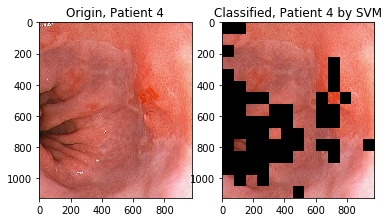

In [57]:
### Plot contour with SCM
contourPlot(frame,clf_SVM,'SVM',scaler)

The following part is for CNN

In [40]:
# Split the train and the validation set for the fitting
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=0)

In [41]:
##Normalization for better performance with CNN
X_train = X_train / 255.0
X_test = X_test / 255.0

In [42]:
### Structure of CNN -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()
model.add(Conv2D(filters = 32, strides=2, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (75,75,3)))
model.add(Conv2D(filters = 32, strides=2, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation = "sigmoid"))

In [43]:
### Compile the model
model.compile(optimizer = 'adam' , loss = "binary_crossentropy", metrics=["accuracy"])

In [87]:
### Fit the model
model.fit(X_train, y_train, 
          batch_size=32, epochs=50, 
          verbose=1, validation_data=(X_val,y_val))

Train on 640 samples, validate on 160 samples
Epoch 1/50
640/640 [==============================] - 5s 8ms/step - loss: 0.6529 - acc: 0.6109 - val_loss: 0.4748 - val_acc: 0.7438
Epoch 2/50
640/640 [==============================] - 4s 7ms/step - loss: 0.6029 - acc: 0.6484 - val_loss: 0.4902 - val_acc: 0.8000
Epoch 3/50
640/640 [==============================] - 4s 7ms/step - loss: 0.5162 - acc: 0.7469 - val_loss: 0.4072 - val_acc: 0.7875
Epoch 4/50
640/640 [==============================] - 4s 7ms/step - loss: 0.4974 - acc: 0.7578 - val_loss: 0.3987 - val_acc: 0.8000
Epoch 5/50
640/640 [==============================] - 5s 7ms/step - loss: 0.4895 - acc: 0.7750 - val_loss: 0.4050 - val_acc: 0.8187
Epoch 6/50
640/640 [==============================] - 4s 7ms/step - loss: 0.4781 - acc: 0.7937 - val_loss: 0.3955 - val_acc: 0.8438
Epoch 7/50
640/640 [==============================] - 4s 7ms/step - loss: 0.4783 - acc: 0.7750 - val_loss: 0.3877 - val_acc: 0.8125
Epoch 8/50
640/640 [==========

In [48]:
### Hard predicted value.
y_predict = (model.predict(X_test)>=0.5).astype('int')

In [49]:
print('Accuracy:%.2f'%accuracy_score(y_test,y_predict))

Accuracy:0.93


In [50]:
### Get tn, fp, fn, tp to calculate sensitivity and specificity
tn, fp, fn, tp = confusion_matrix(y_test,y_predict).ravel()

In [51]:
print('Sensitivity:%.2f\nSpecificity:%.2f'% (tp/(tp+fn),tn/(tn+fp)))

Sensitivity:0.89
Specificity:0.95


In [52]:
### For reproducibility
# Save model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# Save weights to HDF5
model.save_weights("model.h1")

In [46]:
# load json and create model
json_file = open('modelt.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("modelt.h1")

In [47]:
### Compile the model
model.compile(optimizer = 'adam',loss = "binary_crossentropy", metrics=["accuracy"])

The black part represents detected cancerous tissue


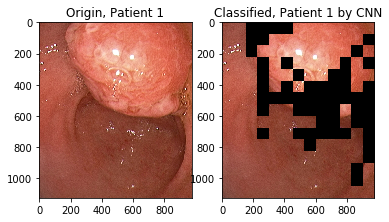

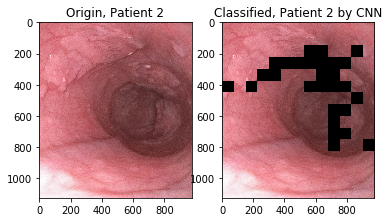

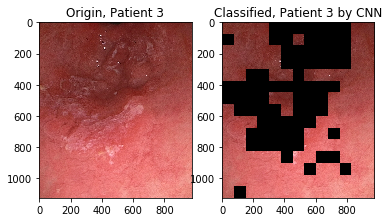

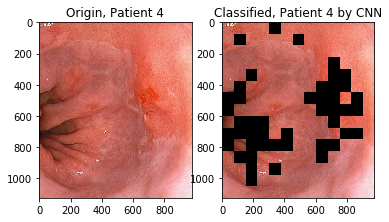

In [58]:
### Plot contour with CNN
contourPlot(frame,model,'CNN',None)